# Filtracja bilateralna

## Konwolucja obrazu z filtrem o zadanych współczynnikach

Splot (konwolucję) obrazu wejściowego $I$ z filtrem $\psi$ dla ustalonego punktu obrazu $\mathbf{x}$ można przedstawić następująco:

\begin{equation}
\hat{I}(\mathbf{x}) = \frac{1}{W_N}\sum_{\mathbf{p} \in \eta(\mathbf{x})} \psi(||\mathbf{p}-\mathbf{x}||)I(\mathbf{p})
\end{equation}

gdzie:
- $\hat{I}$ jest obrazem wynikowym (przefiltrowanym),
- $W_N = \sum_y \psi(y)$ jest parametrem normalizującym współczynniki filtra $\psi$,
- $||\cdot||$ jest odległością między punktami obrazu $\mathbf{x}$ i $\mathbf{p}$ według ustalonej metryki (np. norma $L_2$). Uwaga, proszę pamiętać, że zarówno $\mathbf{x}$, jak i $\mathbf{p}$ to współrzędne przestrzenne,
- $\eta(\mathbf{x})$ jest otoczeniem punktu $\mathbf{x}$.

Funkcja $\psi$ decyduje o charakterze filtracji. Dla filtru Gaussowskiego:

\begin{equation}
\psi(y) = G_{\delta_s}(y)
\end{equation}

gdzie: $G_{\delta_s}(y)$ jest funkcją Gaussa z parametrem skali $\delta_s$.

Opisaną powyżej filtrację realizowaliśmy w ramach ćwiczenia "Przetwarzanie wstępne. Filtracja kontekstowa."

## Filtracja bilateralna

Wadą klasycznego splotu jest brak adaptacji współczynników filtra do lokalnego otoczenia $\eta(\mathbf{x})$ filtrowanego punktu $\mathbf{x}$.
Oznacza to wykorzystanie tych samych współczynników filtra $\psi$ niezależnie od tego czy otoczenie jest względnie jednorodne lub zawiera krawędzie obiektów (w tym przypadku dochodzi do "rozmywania" krawędzi).
Filtracja bilateralna uwzględnia lokalne otoczenie filtrowanego punktu, w ten sposób, że parametry filtra zmieniają się w zależności od "wyglądu" otocznia.


Współczynniki filtra obliczane są na podstawie odległości filtrowanego punktu $\mathbf{x}$ od każdego punktu otoczenia $\mathbf{p}$ w dziedzinie przestrzennej obrazu (tak jak przy typowym filtrze np. Gaussa) oraz odległości punktów w przeciwdziedzinie obrazu (np. na podstawie różnicy w jasności pikseli dla obrazu w odcieniach szarości):

\begin{equation}
\hat{I}(\mathbf{x}) = \frac{1}{W_N}\sum_{\mathbf{p} \in \eta(\mathbf{x})} \psi(||\mathbf{p}-\mathbf{x}||) \gamma(|I(\mathbf{p}) - I(\mathbf{x})|) I(\mathbf{p})
\end{equation}
gdzie:
- $W_N$ jest współczynnikiem normalizującym filtr,
- $\gamma$ jest funkcją odległości w przeciwdziedzinie obrazu, np. $\gamma(y)=\exp(-\frac{y^2}{2\delta_r^2})$
- parametr $\delta_r$ jest utożsamiany z poziomem szumu w obrazie i należy go dobrać w sposób empiryczny.

Proszę chwilę zastanowić się nad powyższym równaniem, w szczególności nad funkcją $\gamma$. Proszę wyznaczyć, jaka będzie wartość funkcji dla pikseli podobnych (różnica 0, 1, 2), a skrajnie różnych (255, 200).

##  Realizacja ćwiczenia

### Wczytanie danych

1. Wczytaj dane z pliku *MR_data.mat*. W tym celu wykorzystaj funkcję `loadmat` z pakietu scipy:
        from scipy.io import loadmat
        mat = loadmat('MR_data.mat')

2. Wczytany plik zawiera 5 obrazów: *I_noisefree*, *I_noisy1*, *I_noisy2*, *I_noisy3* oraz *I_noisy4*. Odczytać je można w następujący sposób:
        Input = mat['I_noisy1']

3.Wyświetl wybrany obraz z pliku *MR_data.mat*. Zagadka - co to za obrazowanie medyczne?

In [4]:
import cv2
import os
import requests
from matplotlib import pyplot as plt
import numpy as np
from scipy import signal
from scipy.io import loadmat
import math

url = 'https://raw.githubusercontent.com/vision-agh/poc_sw/master/07_Bilateral/'

fileNames = ["MR_data.mat"]
for fileName in fileNames:
  if not os.path.exists(fileName):
      r = requests.get(url + fileName, allow_redirects=True)
      open(fileName, 'wb').write(r.content)

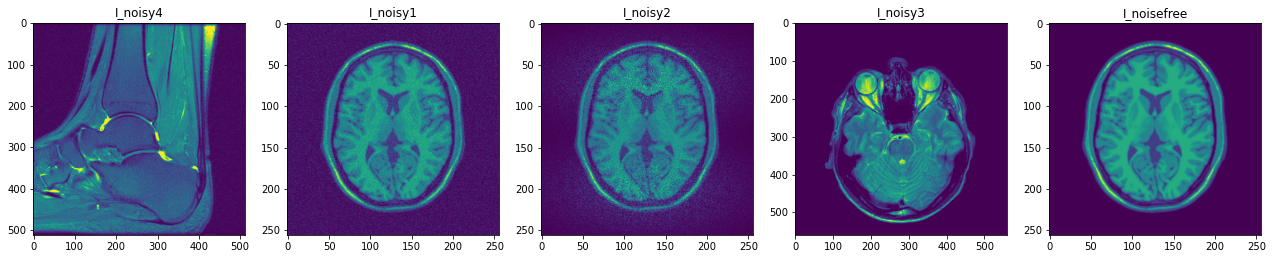

In [5]:
from scipy.io import loadmat
mat = loadmat('MR_data.mat')
layers = [k for k in mat.keys() if not k.startswith("_")]

fig, axs = plt.subplots(ncols=len(layers), figsize=(22,7))
for ax, l in zip(axs, layers):
    ax.imshow(mat[l])
    ax.set_title(l)

### "Klasyczna" konwolucja

1. Zdefiniuj parametry filtra Gaussowskiego: rozmiar okna i wariancję $\delta_S$.
2. Oblicz współczynniki filtra na podstawie zdefiniowanych parametrów (najprościej w ramach podwójnej pętli for).
2. Sprawdź ich poprawność i zwizualizuj filtr (tak jak w ćwiczeniu pt. "Przetwarzanie wstępne. Filtracja kontekstowa.").
3. Wykonaj kopię obrazu wejściowego: `IConv = Input.copy()`
4. Wykonaj podwójną pętlę po obrazie. Pomiń ramkę, dla której nie jest zdefiniowany kontekst o wybranej wielkości.
5. W każdej iteracji stwórz dwuwymiarową tablicę zawierającą aktualny kontekst.
6. Napisz funkcję, która będzie obliczała nową wartość piksela.
Argumentem tej funkcji są aktualnie przetwarzane okno i współczynniki filtra.
7. Obliczoną wartość przypisz do odpowiedniego piksela kopii obrazu wejściowego.
8. Wyświetl wynik filtracji.
9. Porównaj wynik z obrazem oryginalnym.

In [25]:
from scipy.stats import norm

def gaussian_window(window_size=5, sigma=1):
    dist = np.square(np.arange(window_size) - window_size//2)
    dist = np.sqrt(dist.reshape(-1, 1) + dist.reshape(1, -1))
    w = norm.pdf(dist, scale=sigma)
    return w / w.sum()

In [55]:
def convolve(img, window):
    img_copy = img.copy()
    for i in range(img.shape[0] - window.shape[0]):
        for j in range(img.shape[1] - window.shape[1]):
            frame = img[i:i+window.shape[0], j:j+window.shape[1]]
            img_copy[i+window.shape[0]//2, j+window.shape[1]//2] = (frame * window).sum()
        
    return img_copy.astype('uint8')
            

In [127]:
def plot_conv(img, img_conv):
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20, 7), gridspec_kw={'width_ratios': [4,4,5.1]})
    ax1.imshow(img)
    ax1.set_title("Original")
    ax2.imshow(img_conv)
    ax2.set_title("Convolved")
    
    diff = img.astype(int) - img_conv.astype(int)
    sns.heatmap(diff, cmap = 'coolwarm', ax=ax3, square=True)
    ax3.axis('off')
    ax3.set_title("Difference")
    

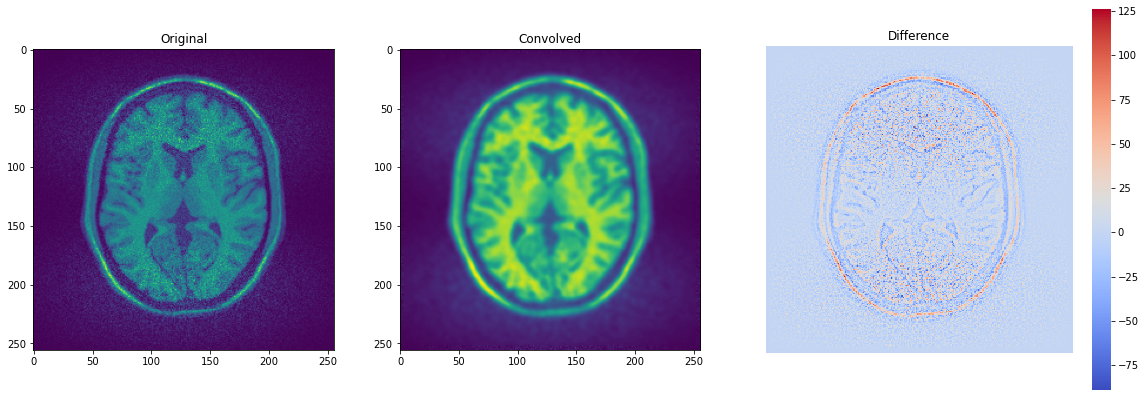

In [128]:
img = mat['I_noisy2']
img_conv = convolve(img, gaussian_window(7, 2))
plot_conv(img, img_conv)

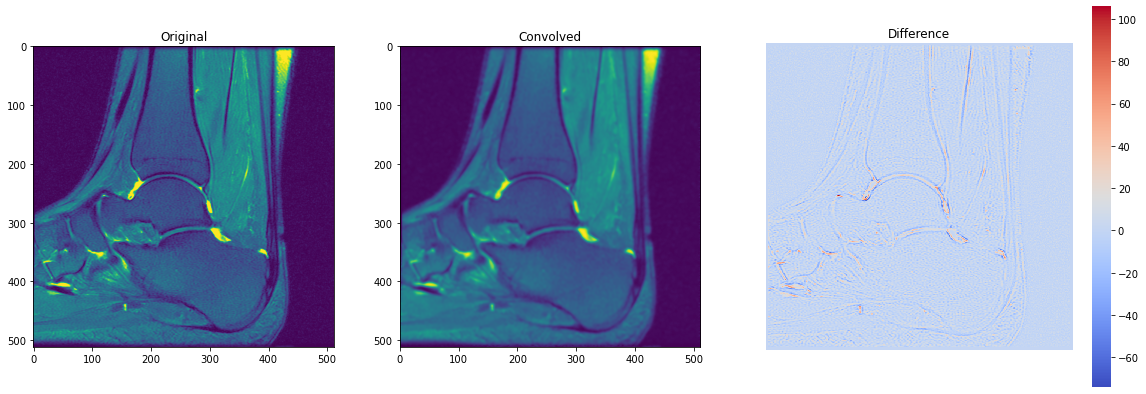

In [129]:
img = mat['I_noisy4']
img_conv = convolve(img, gaussian_window(7, 2))
plot_conv(img, img_conv)

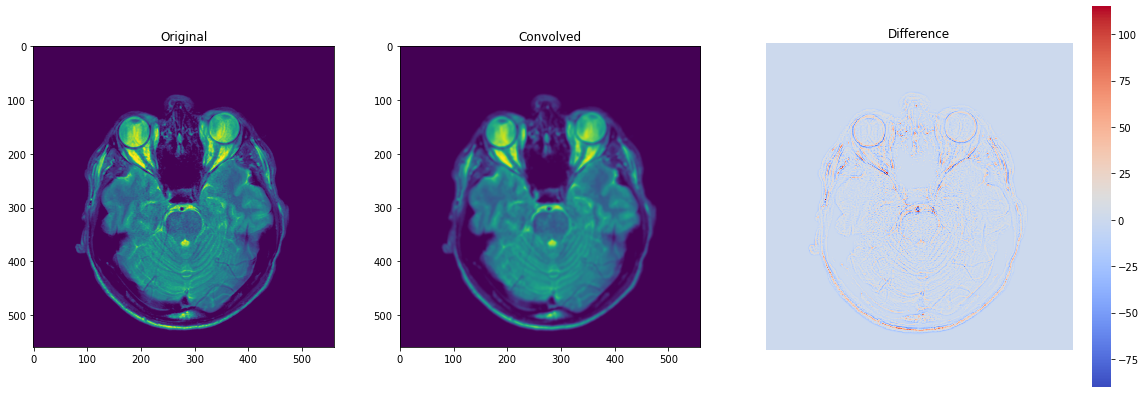

In [130]:
img = mat['I_noisy3']
img_conv = convolve(img, gaussian_window(7, 2))
plot_conv(img, img_conv)

### Filtracja bilateralna

1. Zdefiniuj dodatkowy parametr: wariancję $\delta_R$.
3. Wykonaj kopię obrazu wejściowego: `IBilateral = Input.copy()`
4. Wykonaj podwójną pętlę po obrazie. Pomiń ramkę, dla której nie jest zdefiniowany kontekst o wybranej wielkości.
5. W każdej iteracji stwórz dwuwymiarową tablicę zawierającą aktualny kontekst.
6. Napisz funkcję, która będzie obliczała nową wartość piksela.
Argumentami funkcji są aktualnie przetwarzane okno, współczynniki filtra gausowskiego (takie same jak wcześniej) i wariancja $\delta_R$.
7. Oblicz odległość w przeciwdziedzinie (dla wartości pikseli).
8. Oblicz funkcję Gaussa dla obliczonych odległości z zadanym parametrem.
9. Wykonaj normalizację obliczonych współczynników.
10. Obliczoną wartość przypisz do odpowiedniego piksela kopii obrazu wejściowego.
11. Wyświetl wynik filtracji.
12. Porównaj wynik z obrazem oryginalnym.

In [118]:
def uhhh(x, delta_r=40):
    return np.exp((-1/2) * np.square(x/delta_r))

In [119]:
def convolve_bilateral(img, window):
    img_copy = img.copy()
    for i in range(img.shape[0] - window.shape[0]):
        for j in range(img.shape[1] - window.shape[1]):
            frame = img[i:i+window.shape[0], j:j+window.shape[1]]
            dist = uhhh(frame - img[i+window.shape[0]//2, j+window.shape[1]//2])
            f = (window * dist)
            img_copy[i+window.shape[0]//2, j+window.shape[1]//2] = (frame * f/f.sum()).sum()             
        
    return img_copy.astype('uint8')
            

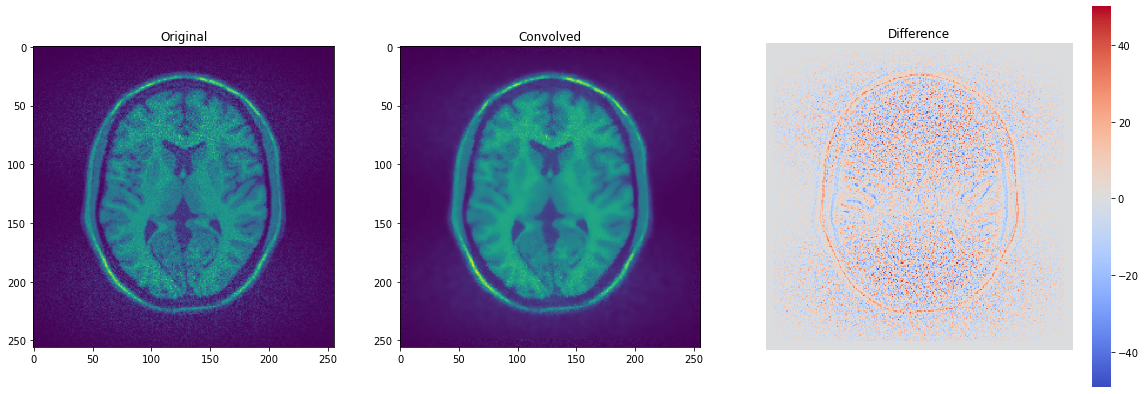

In [132]:
img = mat['I_noisy2']
img_conv = convolve_bilateral(img, gaussian_window(13, 2))
plot_conv(img, img_conv)

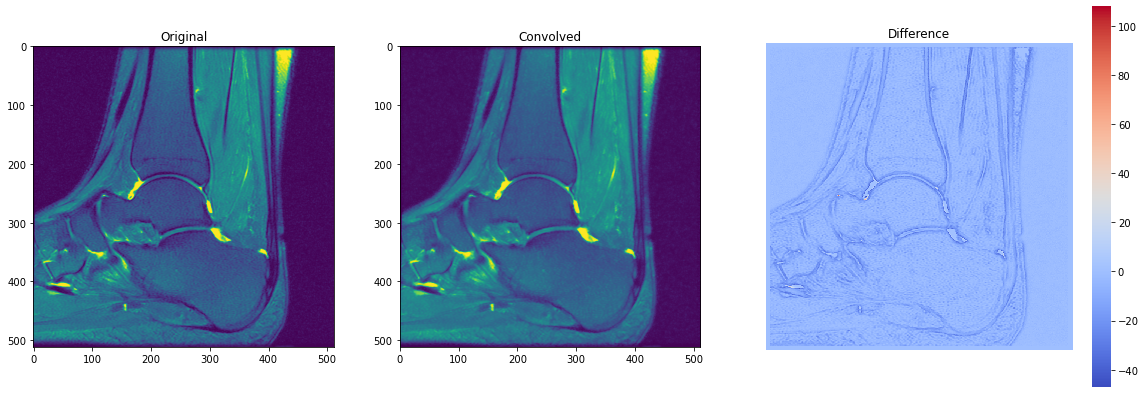

In [133]:
img = mat['I_noisy4']
img_conv = convolve_bilateral(img, gaussian_window(13, 2))
plot_conv(img, img_conv)

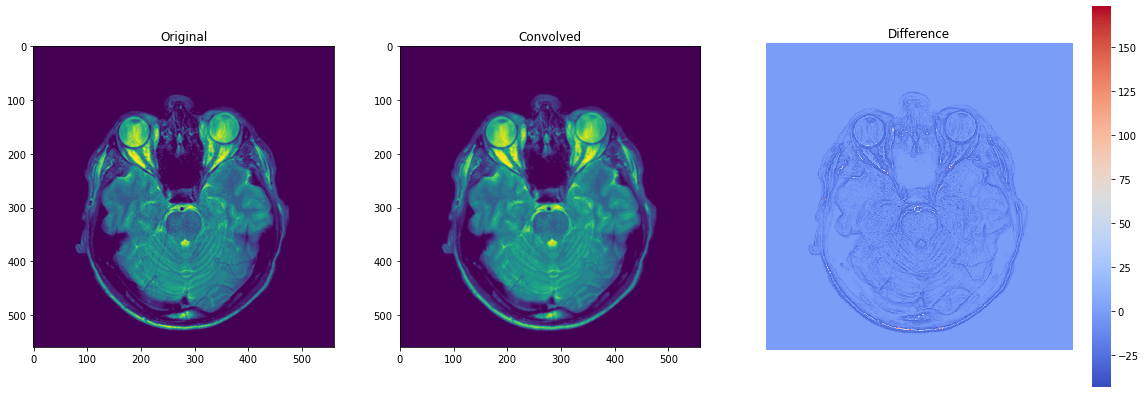

In [134]:
img = mat['I_noisy3']
img_conv = convolve_bilateral(img, gaussian_window(13, 2))
plot_conv(img, img_conv)